# Сокращение размерности

### EM алгоритм

Напомним, как выглядит $EM$ алгоритм. 

$$
\log p(x|\theta) = \int q(z)\log p(x|\theta)dz = \int q(z)\log\dfrac{p(x,z|\theta)}{p(z|x,\theta)}dz = \int q(z)\log\dfrac{p(x,z|\theta)}{q(z)}dz+\int q(z)\log\dfrac{q(z)}{p(z|x,\theta)}dz = \mathcal{L}(q,\theta)+KL(q(z)|p(z|x,\theta))
$$

** E-step ** 
$$ q(z)^{(n+1)} = p(z|x,\theta^{(n)}) $$
** M-step ** 
$$ \theta^{(n+1)} = \max\limits_{\theta} \mathcal{L}(q^{(n+1)},\theta) $$

### PCA как модель с латентными пременными

Процесс генерации данных в модели PCA выглядит следующим образом:

![Генеративный процесс](pca_illustration.png "Генеративный процесс")

Таким образом, мы получаем модель:

\begin{equation}P(X,T|W,\mu,\sigma^2) = \prod\limits_{n=1}^{N}p(x_n,t_n|W,\mu,\sigma^2) = \prod\limits_{n=1}^{N}\mathcal{N}(x_n|Wt_n+\mu,\sigma^2I)\mathcal{N}(t_n|0,I)
\end{equation}

** Задание 1. ** (5 баллов) Выпишите E и M шаги для модели PCA.


На $E$-шаге $EM$ алгоритма происходит вычисление математических ожиданий. На $M$-шаге происходит максимизация функции правдоподобия.

Рассмотрим совместное распределение элементов $t_j, x_j$:

$p(t_j,x_j) = p(t_j|x_j)p(x_j) = \left(2\pi\sigma^2\right)^{-d/2} \exp\left(-\dfrac{1}{2\sigma^2}||t_j - Wx_j - \mu ||^2\right)(2\pi)^{-1/2}\exp\left(-\dfrac{1}{2}x_j^Tx_j\right)$

Получаем следующее полное совместное распределение $T$, $X$:

$p(T,X) = \prod\limits_{j=1}^{N}p(t_j,x_j) = \left(2\pi\sigma^2\right)^{-Nd/2}\exp\left(-\dfrac{1}{2\sigma^2}\sum\limits_{j=1}^{N}||t_j - Wx_j - \mu||^2\right)(2\pi)^{-N/2}\exp\left(-\dfrac{1}{2}\sum\limits_{j=1}^{N}x_j^Tx_j\right)$

Рассмотрим логарифм правдоподобия условного полного совместного распределения:

$\ell = \ln\left(p(T,X | W,\mu, \sigma^2)\right) = -\dfrac{N}{2}(1+d)\ln(2\pi) - \dfrac{Nd}{2}\ln(\sigma^2) - \dfrac{1}{2\sigma^2}\left(\sum\limits_{j=1}^{N}||t_j - Wx_j - \mu||^2\right) - \dfrac{1}{2}\left(\sum\limits_{j=1}^{N}x_j^Tx_j\right)$

Посчитаем распределение $x_j$ при условии $t_j$ по формуле Байеса:

$p(x_j|t_j) = (2\pi)^{-q/2}|\sigma^{-2}M|^{1/2}\exp\left(-\dfrac{1}{2}\left(x_j-M^{-1}W^T(t_j - \mu)\right)^T(\sigma^{-2}M)\left(x_j-M^{-1}W^T(t_j - \mu)\right)\right)$

где $M = W^TW+\sigma^2I$ - ковариационная матрица.

Получаем, что $p(x_j|t_j)$ распределена нормально:

$p(x_j|t_j) \sim \mathcal{N}\left(M^{-1}W^T(t_j-\mu), \sigma^2M^{-1}\right)$

Считаем матожидание логарифма правдоподобия:

$\mathbb{E}\ell = -\dfrac{1}{2}(1+d)\ln(2\pi)-\dfrac{d}{2}\ln(\sigma^2) - \dfrac{1}{2\sigma^2}tr\big((T-\mu e_N^T)(T-\mu e_N^T)^T - 2(T-\mu e_N^T)\mathbb{E}(X)^T W^T + W\mathbb{E}(XX^T) W^T\big) + \dfrac{1}{2}tr\left(\mathbb{E}(XX^T)\right)$, где

$\mathbb{E}(X)  = M^{-1}W^T\left(T-\mu e_N^T\right)$

$\mathbb{E}(XX^T) = \sigma^2M^{-1}+\mathbb{E}(X) \mathbb{E}(X)^T$

где $\mu \in \mathbb{R}^d$ - вектор средних, $e_N$ - вектор с $N$ единицами

Приравнивая к нулю производную логарифма правдоподобия получаем следующие оценки:

$\widetilde{W} = SW\left(\sigma^2 I + M^{-1}W^TSW\right)^{-1}$

$\widetilde{\sigma} = \dfrac{1}{d}tr\left(S - SWM^{-1}\widetilde{W}^T\right)$

где $S = \dfrac{1}{N}\left(T-\mu e_N^T\right)\left(T-\mu e_N^T\right)^T$

Получаем следующие шаги $EM$ алгоритма:

$E$-шаг:

$X   = \left(W^TW\right)^{-1}W^T\left(T-\mu e_N^T\right)$

$M$-шаг:

$\widetilde{W} = \left(T-\mu e_N^T\right)X^T\left(XX^T\right)^{-1}$

** Задание 2. ** (5 баллов) Реализуйте EM алгоритм для модели PCA

In [24]:
import numpy as np
from numpy.linalg import inv

# будем совершать Е и М шаги до сходимости

def EMPCA(X,W,T,mu, N):
    X = np.array(X)
    W = np.array(W)
    T = np.array(T)
    mu = np.array(mu)
    e = np.ones((N,1))
    
    X_new = np.dot(inv(np.dot(W.T, W)), W.T)
    X_new = np.dot(X_new, T - np.dot(mu, e))
    
    W_new = np.dot(T - np.dot(mu, e), X_new.T)
    W_new = np.dot(W_new, inv(np.dot(X_new, X_new.T)))
    
    if np.isclose(W_new, W):
        return W_new
    else:
        EMPCA(X_new, W_new, T, mu, N)

** Задание 3. ** (10 баллов) Используя свою реализацию метода PCA, решите задачу восстанавления давления по профилю крыла.

In [138]:
import pandas as pd
import numpy as np
import math
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

data = pd.read_csv("A2P.txt", header=None, sep=' ')

data = data.drop(114, axis=1)

newdata = np.array(data)

X_train, X_test, y_train, y_test = train_test_split(newdata, newdata, test_size=0.25)

profile = X_train[:,:57]
pressure = X_train[:,57:]

In [139]:
def Algorithm(profile, pressure, N):
    pca = PCA(n_components=N)
    pca.fit(profile)
    profile_comp = pca.components_

    pca = PCA(n_components=N)
    pca.fit(pressure)
    pressure_comp = pca.components_

    components = np.concatenate((profile_comp, pressure_comp), axis=1)

    means = np.mean(X_train, axis=0)

    X_train_norm = np.zeros((X_train.shape))

    for i in range(len(X_train)):
        X_train_norm[i] = X_train_norm[i] - means

    X_train_chosen = X_train_norm[:N]

    lambdas = np.zeros(N)

    for i in range(N):
        lambdas[i] = np.dot(X_train_chosen[i], components[i])

    profile_means = np.mean(profile, axis=0)
    pressure_means = np.mean(pressure, axis=0)

    sum_A = 0
    sum_P = 0

    profile_comp_trunc = profile_comp[:,:N]
    pressure_comp_trunc = pressure_comp[:,:N]

    for i in range(N):
        sum_A = sum_A + lambdas[i]*profile_comp_trunc[i]

    for i in range(N):
        sum_P = sum_P + lambdas[i]*pressure_comp_trunc[i]

    A_star = profile_means[:N] + sum_A
    P_star = pressure_means[:N] + sum_P

    # ---

    E = profile_comp.T

    E_pseudo = np.linalg.pinv(E)

    profile_norm = np.zeros((profile.shape))

    for i in range(N):
        profile_norm[i] = profile[i] - profile_means[i]

    profile_chosen = profile_norm[:N]

    lambdas_new = np.dot(E_pseudo, profile_chosen.T)
    
    lambdas_final = lambdas_new[0]

    lambdas_final.shape

    P_star_new = 0

    for i in range(N):
        P_star_new = P_star_new + lambdas_final[i]*pressure_comp[i]

    P_star_new = P_star_new + pressure_means

    P_star_new = P_star_new[:N]
    
    error = math.sqrt(np.linalg.norm(pressure[:N].mean(axis=1) - P_star_new)/N)
    
    return error


Populating the interactive namespace from numpy and matplotlib


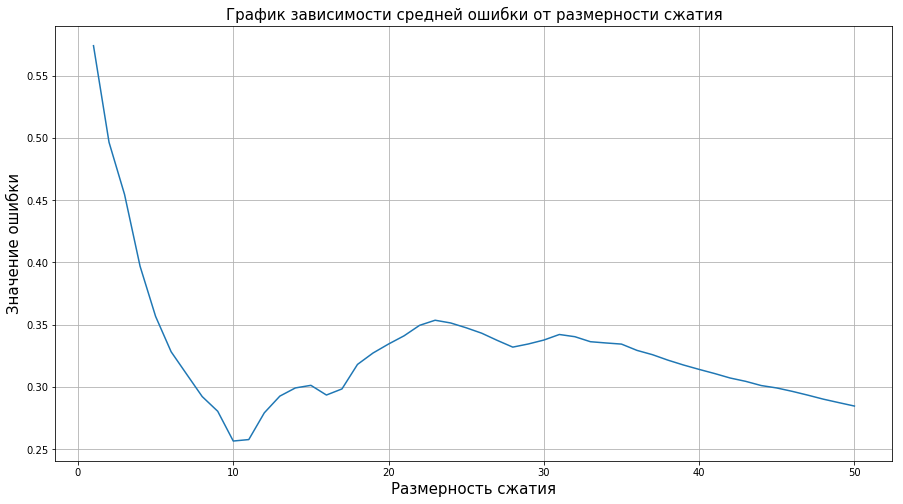

In [141]:
%pylab inline

X = np.arange(1,51)
Y = []

for i in X:
    Y.append(Algorithm(profile, pressure, i))

plt.figure(figsize=(15, 8))
plt.title('График зависимости средней ошибки от размерности сжатия', size=15)
plt.plot(X, Y)
plt.legend()
plt.grid()
plt.xlabel('Размерность сжатия', size=15)
plt.ylabel('Значение ошибки', size=15)
plt.show()

Скачать данные со страницы курса. https://yadi.sk/i/065iNGXp3QYv5n

Данные представляют собой матрицу размера $397\times114$; в каждой
строке находится подвектор, описывающий профиль (первые 57
координат), и подвектор, описывающий соответствующее распределение
давления (следующие 57 координат). Задача состоит в том, чтобы на
основании метода главных компонент построить алгоритм, позволяющий
восстанавливать распределение давления по профилю. Опишем алгоритм
обучения и алгоритм восстановления. Пусть ${\bf A}\in\mathbb{R}^{57}$ --
вектор, описывающий профиль, а ${\bf P}\in\mathbb{R}^{57}$ -- вектор,
описывающий распределение давления. Дана обучающая выборка $({\bf
A}_i,{\bf P}_i)_{i=1}^N$ (взять в качестве обучающей выборки 75%
случайно выбранных строк из матрицы данных; остальные 25%
использовать в качестве тестового множества данных).

Алгоритм обучения состоит из следующих шагов:


1. По данным $({\bf A}_i,{\bf P}_i)_{i=1}^N$ оцениваются первые
$d$ (параметр алгоритма) главных компонент ${\bf e}_1,\ldots,{\bf
e}_d$, где ${\bf e}_i\in\mathbb{R}^{114}$. 
2. Каждый из векторов ${\bf e}_i,i=1,\ldots,d$ представляется как объединение двух подвекторов
${\bf e}_i = ({\bf e}_i^A\in\mathbb{R}^{57},{\bf
e}_i^P\in\mathbb{R}^{57}),i=1,\ldots,d$, соответствующих описанию профиля
и распределению давления соответственно.


Преобразование произвольного объединенного вектора ${\bf Z} =
({\bf A},{\bf P})$ в сжатое описание ${\bf\lambda}=(\lambda_1,\ldots,\lambda_d)$ происходит согласно
следующей формуле:

$$
\lambda_i = \left( {\bf Z}-{\bf Z}_{\mathrm{mean}},{\bf e}_i\right),
i=1,\ldots,d,
$$

где ${\bf Z}_{\mathrm{mean}} = \frac{1}{N}\sum_{k=1}^N {\bf Z}_k$,
${\bf Z}_k = ({\bf A}_k,{\bf P}_k)$ (выборочное среднее;
подсчитывается по обучающей выборке). Восстановления подвекторов
${\bf A}$ и ${\bf P}$ объединенного вектора ${\bf Z} = ({\bf
A},{\bf P})$ по сжатому описанию ${\bf
\lambda}=(\lambda_1,\ldots,\lambda_d)$ происходит согласно
формулам

$$
{\bf A}^*({\bf \lambda}) = {\bf A}_{\mathrm{mean}} + \sum_{i=1}^d\lambda_i{\bf e}_i^A,\,{\bf
P}^*({\bf \lambda}) ={\bf P}_{\mathrm{mean}} + \sum_{i=1}^d\lambda_i{\bf e}_i^P.
$$


Алгоритм восстановления давления ${\bf P}$ по профилю ${\bf A}$
может быть описан следующим образом:


1. Для заданного профиля ${\bf A}$ определяются такие ${\bf
\lambda}=(\lambda_1,\ldots,\lambda_d)$, что $\|{\bf A}^*({\bf
\lambda})-{\bf A}\|_{2}^2$ принимает минимальное значение (такое
значение ${\bf \lambda}$ подсчитывается с помощью псевдообращения
матрицы $E=[{\bf e}_1^A,\ldots,{\bf e}_d^A]$, то есть ${\bf
\lambda} = E^{+}\left({\bf A}-{\bf A}_{\mathrm{mean}}\right)$, где $E^+$ -- псевдообратная матрица).
2. По вычисленному вектору ${\bf
\lambda}$ оценивается давление согласно формуле \[${\bf P}^*({\bf
\lambda}) = {\bf P}_{\mathrm{mean}} + \sum_{i=1}^d\lambda_i{\bf e}_i^P.$
\]

Задача состоит в том, чтобы реализовать предложенный алгоритм;
подсчитать график зависимости средней ошибки восстановления
векторов давлений из тестовой выборки от размерности сжатия $d$;
нарисовать несколько восстановленных графиков давления (для
нескольких разных профилей) с наложением истинных значений
давления. Ошибка между набором векторов $({\bf P}_i)_{i=1}^M$ и
восстановленными векторами $({\bf P}^*_i)_{i=1}^M$ оценивается
согласно формуле $\sqrt{\frac{1}{M}\sum_{i=1}^M\|{\bf P}_i-{\bf P}^*_i\|^2}$, где
$\|\cdot\|$ -- евклидово расстояние